# Image Segmentation using *UNet*

- This is a tutorial on image segmentation for bioimages(i.e. fluorescence microscopy data) using UNet

## 1. Importing Modules & Packages

In [12]:
# Libraries for handling URL and file operations
import urllib                     # Library for handling URL operations
import os                         # Library for interacting with the operating system
import zipfile                    # Library for handling zip file operations

# Libraries for numerical and scientific computation
import numpy as np                # NumPy: manipulation of numerical arrays
import scipy.ndimage as ndi       # The image processing package scipy.ndimage
from scipy.ndimage import gaussian_filter  # Gaussian filter function from scipy.ndimage
from math import log10            # Math library for logarithmic calculations
import random                     # Library for random number generation

# Libraries for data visualization and plotting
import matplotlib.pyplot as plt   # The plotting module matplotlib.pyplot as plt
import seaborn as sns             # Seaborn: data visualization library
import pandas as pd               # Pandas: data manipulation and analysis library
import time                       # Time library for measuring execution time

# Libraries for image processing and handling
from PIL import Image             # Pillow: image processing library
from skimage import io            # Scikit-image: image I/O
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


from albumentations import (
    Compose, Resize, HorizontalFlip, VerticalFlip, Rotate, Normalize
)
from albumentations.pytorch import ToTensorV2

# Libraries for machine learning and neural networks
import torch                      # PyTorch: deep learning library
import torch.nn as nn             # PyTorch neural network module
import torch.optim as optim       # PyTorch optimization module
from torch.utils.data import DataLoader, Dataset, random_split  # DataLoader and Dataset modules from PyTorch
from torchvision import transforms  # Transforms module from torchvision for image transformations
from torchsummary import summary    # Summary module from torchsummary for model summary

In [2]:
# Set matplotlib backend
%matplotlib inline
#%matplotlib inline              # Displays as static figure in code cell output
#%matplotlib notebook            # Displays as interactive figure in code cell output
#%matplotlib qt                  # Displays as interactive figure in a separate window

In [3]:
# Check GPU
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
# Allocate memory on the GPU dynamically
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'    # Allow GPU memory to grow as needed

True
Tesla T4


In [4]:
# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# DataLoader setup
def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)


# Set seeds for reproducibility
set_seed(42)


## 2. Importing and save data

In [5]:
# check if data has been downloaded already
zipPath = "/content/small_data.zip"
extractPath = "/content/data0"  # Destination folder

with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(extractPath)

print(f"Data extracted to {extractPath}")

Data extracted to /content/data0


## 3. Ploting image example from the training set

In [6]:
# Function to plot pairs of images

def pltPair(img1, img2, title1, title2, cmap1, cmap2, lim, fig_size):
    """This function displays a pair of input image with interpolation='none',in the range of lims. """

    plt.figure(figsize=(fig_size,fig_size))
    plt.subplot(1,2,1)
    plt.imshow(img1, interpolation='none', cmap=cmap1, vmin=lim[0], vmax=lim[1])
    plt.title(title1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(1,2,2)
    plt.imshow(img2, interpolation='none', cmap=cmap2, vmin=lim[2], vmax=lim[3])
    plt.title(title2)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()



## 4. Image Segmentation using UNet


### Load images

In [50]:
# Custom dataset for loading images
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        """
        Custom Dataset for segmentation.

        Args:
            image_paths (list): List of paths to input images.
            mask_paths (list): List of paths to masks.
            transform (callable, optional): Transform to apply.
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = io.imread(self.image_paths[idx]).astype(np.float32)
        mask = io.imread(self.mask_paths[idx]).astype(np.float32)

        # Normalize images to [0, 1] and Convert mask to binary if needed
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        mask = (mask > 0).astype(np.uint8)

        # Convert to PIL for transforms
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


In [51]:
class AlbumentationsTransform:
    def __init__(self, image_size=(128, 128), augment=False):
        if augment:
            self.transform = Compose([
                Resize(image_size[0], image_size[1]),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                #Rotate(limit=180, p=0.5),  #rotation
                #Normalize(mean=(0.0,), std=(1.0,)),  # normalize to [0,1]
                ToTensorV2()
            ])
        else:
            self.transform = Compose([
                Resize(image_size[0], image_size[1]),
                #Normalize(mean=(0.0,), std=(1.0,)),
                ToTensorV2()
            ])

    def __call__(self, image, mask):
        # Albumentations expects numpy arrays
        image = np.array(image)
        mask = np.array(mask)

        # Apply transform
        augmented = self.transform(image=image, mask=mask)
        image = augmented["image"]
        mask = augmented["mask"].float().unsqueeze(0)  # shape [1, H, W]

        return image, mask


In [52]:
train_images_dir = '/content/data0/zfish/training/images/'
train_masks_dir = '/content/data0/zfish/training/masks/'
test_images_dir = '/content/data0/zfish/test/images/'
test_masks_dir = '/content/data0/zfish/test/masks/'



# Collect file paths
image_files = sorted([os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir)])
mask_files = sorted([os.path.join(train_masks_dir, f) for f in os.listdir(train_masks_dir)])

# Split into train and validation
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# Test set paths
test_img_paths = sorted([os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir)])
test_mask_paths = sorted([os.path.join(test_masks_dir, f) for f in os.listdir(test_masks_dir)])


In [53]:
# Custom dataset for loading images
# Image size and batch settings
image_size = (128, 128)
batch_size = 32

train_transform = AlbumentationsTransform(image_size=image_size, augment=True)  # Augmentations ON
val_test_transform = AlbumentationsTransform(image_size=image_size, augment=False)  # Augmentations OFF


# Create Datasets & Loaders

train_dataset = SegmentationDataset(train_img_paths, train_mask_paths, transform=train_transform)
val_dataset = SegmentationDataset(val_img_paths, val_mask_paths, transform=val_test_transform)
test_dataset = SegmentationDataset(test_img_paths, test_mask_paths, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print(f"Train samples: {len(train_dataset)}, batches: {len(train_loader)}")
print(f"Validation samples: {len(val_dataset)}, batches: {len(val_loader)}")
print(f"Test samples: {len(test_dataset)}, batches: {len(test_loader)}")

Train samples: 720, batches: 23
Validation samples: 180, batches: 6
Test samples: 450, batches: 15


## Plot some images as examples

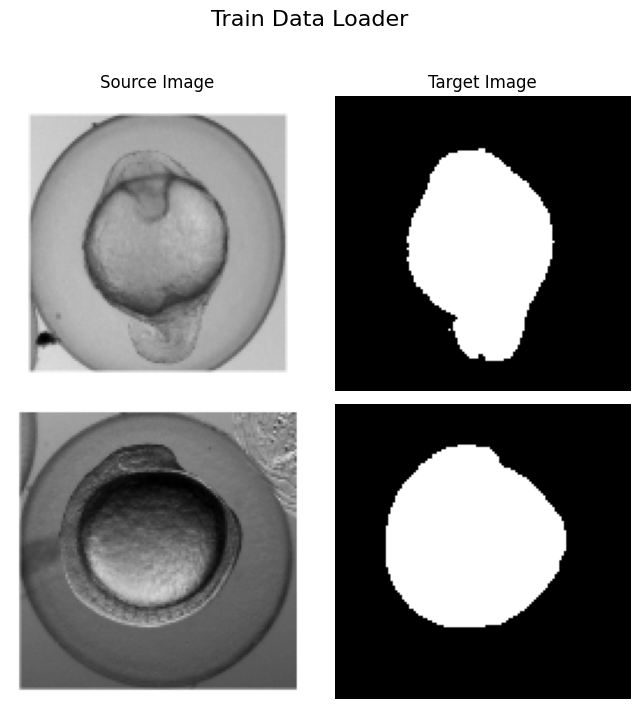

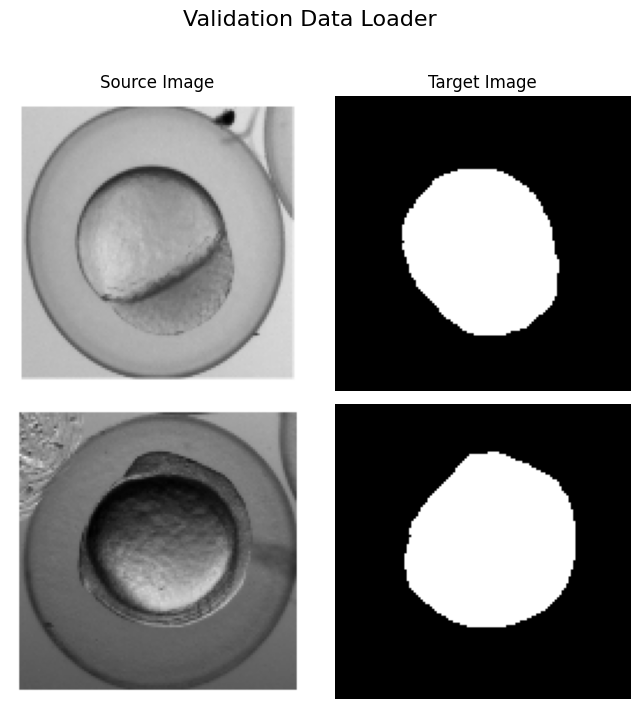

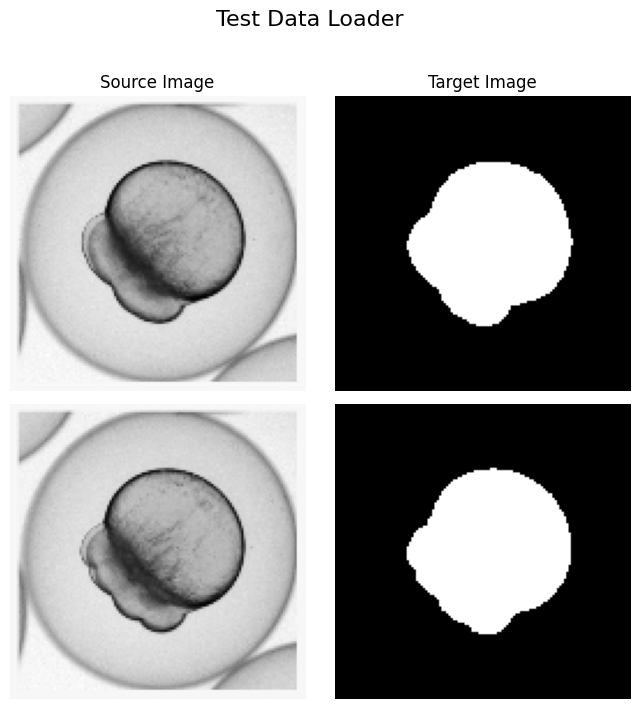

In [54]:
# Function to plot image pairs
def plot_image_pairs(data_loader, title, Nimages):
    data_iter = iter(data_loader)
    fig, axes = plt.subplots(nrows=Nimages, ncols=2, figsize=(8, 4*Nimages))
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(wspace=0.1, hspace=0) # Adjust the spacing between subplots
    noisy_images, masks = next(data_iter) # get N pairs of images, N = batchc size

    # Plot fewer image pairs than the batch size
    if Nimages > noisy_images.shape[0]:
        Nimages = noisy_images.shape[0]

    for i in range(Nimages):
      axes[i, 0].imshow(np.squeeze(noisy_images[i]),cmap='gray')
      axes[i, 0].axis('off')
      axes[i, 1].imshow(np.squeeze(masks[i]),cmap='gray')
      axes[i, 1].axis('off')
      if i == 0:
          axes[i, 0].set_title('Source Image', fontsize=12)
          axes[i, 1].set_title('Target Image', fontsize=12)
    plt.show()

# Plotting train and test image pairs
plot_image_pairs(train_loader, "Train Data Loader", 2)
plot_image_pairs(val_loader, "Validation Data Loader", 2)
plot_image_pairs(test_loader, "Test Data Loader", 2)

## Define UNet model

In [55]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.encoder1 = conv_block(1, 64)
        self.encoder2 = conv_block(64, 128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(128, 256)

        self.upconv2 = up_conv(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = up_conv(128, 64)
        self.decoder1 = conv_block(128, 64)

        self.conv_final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))

        bottleneck = self.bottleneck(self.pool(enc2))

        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))

        return torch.sigmoid(self.conv_final(dec1))


# Initialize model
model = UNet().cuda()
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

## Train Model

Epoch [1/100], Train Loss: 0.6108, Val Loss: 0.5420, Time: 8.54 seconds
Epoch [2/100], Train Loss: 0.5164, Val Loss: 0.5024, Time: 8.37 seconds
Epoch [3/100], Train Loss: 0.4822, Val Loss: 0.4483, Time: 8.61 seconds
Epoch [4/100], Train Loss: 0.4008, Val Loss: 0.3552, Time: 8.63 seconds
Epoch [5/100], Train Loss: 0.3225, Val Loss: 0.3187, Time: 8.59 seconds
Epoch [6/100], Train Loss: 0.2687, Val Loss: 0.2419, Time: 8.51 seconds
Epoch [7/100], Train Loss: 0.1983, Val Loss: 0.2031, Time: 8.59 seconds
Epoch [8/100], Train Loss: 0.1631, Val Loss: 0.1505, Time: 8.48 seconds
Epoch [9/100], Train Loss: 0.1342, Val Loss: 0.1288, Time: 8.34 seconds
Epoch [10/100], Train Loss: 0.1805, Val Loss: 0.1539, Time: 8.49 seconds
Epoch [11/100], Train Loss: 0.1360, Val Loss: 0.1210, Time: 8.60 seconds
Epoch [12/100], Train Loss: 0.1201, Val Loss: 0.1356, Time: 8.45 seconds
Epoch [13/100], Train Loss: 0.1102, Val Loss: 0.1024, Time: 8.63 seconds
Epoch [14/100], Train Loss: 0.1112, Val Loss: 0.1111, Time: 

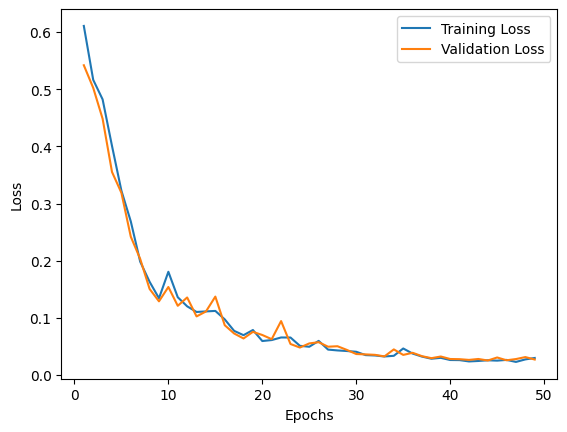

In [56]:
# Training parameters
num_epochs = 100
learning_rate = 0.0001
criterion = nn.BCELoss()    # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
patience = 5  # Early stopping patience


# Store losses
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()  # Start time for epoch
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:

        images = images.cuda()
        masks = masks.cuda()
        outputs = model(images)
        loss = criterion(outputs, masks.float())

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.cuda()
            masks = masks.cuda()
            outputs = model(images)
            loss = criterion(outputs,  masks.float())
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    epoch_time = time.time() - start_time  # Calculate epoch duration
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Plotting the training and validation loss
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Visualize the results

In [61]:
# Import
from skimage.filters.thresholding import threshold_otsu

def thershold_by_Otsu(img):
  thresh = threshold_otsu(img)
  mask = img < thresh
  mask = mask.astype(np.int8)
  #print('Throshold by Otsu = ', thresh)
  return mask

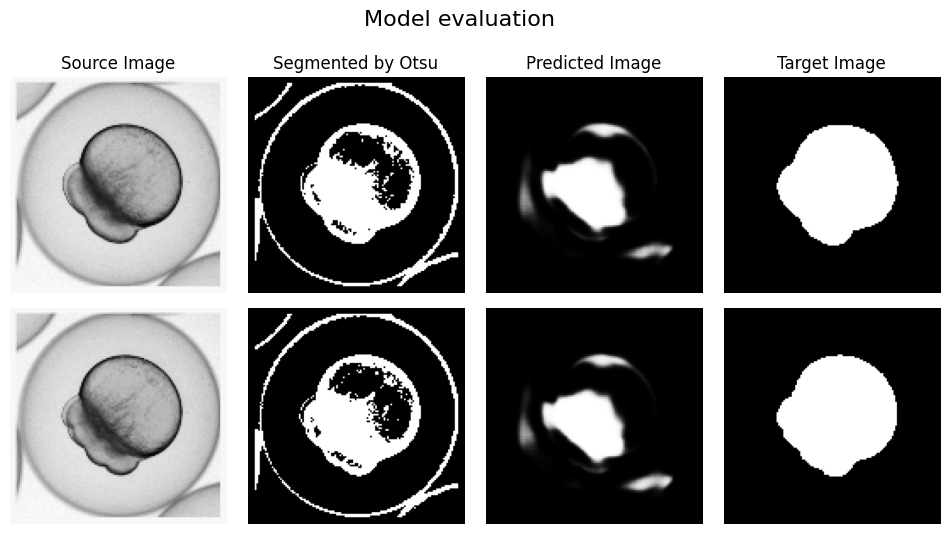

In [63]:
# Model evaluation
NimagesToShow = 2
fig, axes = plt.subplots(nrows=NimagesToShow, ncols=4, figsize=(12, 3*NimagesToShow))
fig.suptitle("Model evaluation", fontsize=16)
fig.subplots_adjust(wspace=0.1, hspace=0) # Adjust the spacing between subplots

model.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    noisy_images, masks = next(data_iter)  # get N pairs of images, N = batch size

    noisy_images = noisy_images.cuda()
    outputs = model(noisy_images)

    noisy_images = noisy_images.cpu()  # Move back to CPU
    outputs = outputs.cpu()            # Move outputs to CPU


    # Plot fewer image pairs than the batch size
    if NimagesToShow > noisy_images.shape[0]:
        NimagesToShow = noisy_images.shape[0]

    for i in range(NimagesToShow):
        axes[i, 0].imshow(np.squeeze(noisy_images[i]),cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(thershold_by_Otsu((noisy_images[i]).cpu().numpy().squeeze()),cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(np.squeeze(outputs[i]),cmap='gray')
        axes[i, 2].axis('off')
        axes[i, 3].imshow(np.squeeze(masks[i]),cmap='gray')
        axes[i, 3].axis('off')
        if i == 0:
            axes[i, 0].set_title('Source Image', fontsize=12)
            axes[i, 1].set_title('Segmented by Otsu', fontsize=12)
            axes[i, 2].set_title('Predicted Image', fontsize=12)
            axes[i, 3].set_title('Target Image', fontsize=12)

plt.show()



## Quantify results

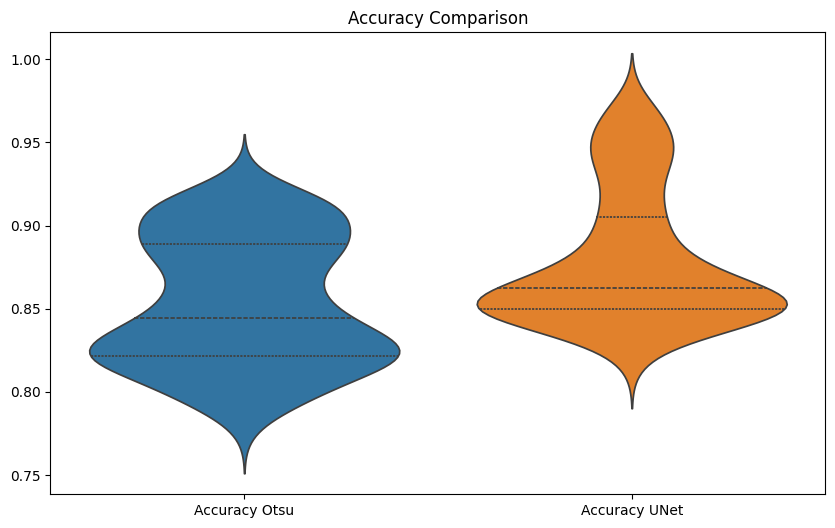

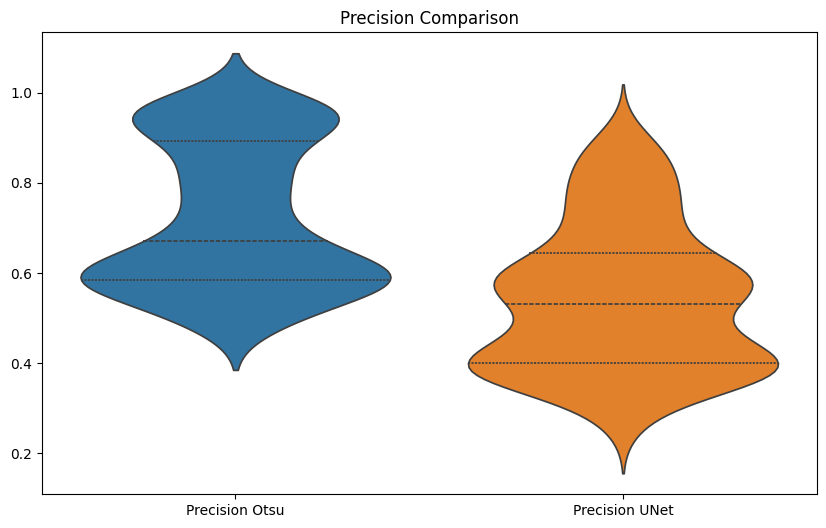

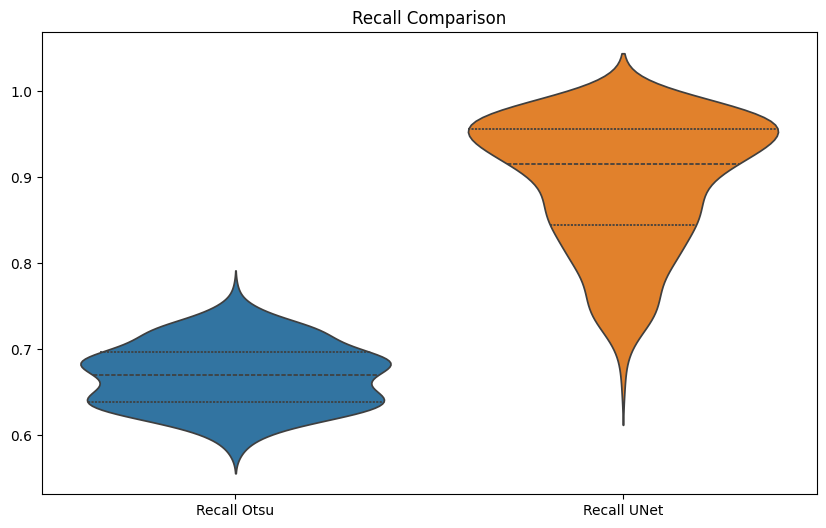

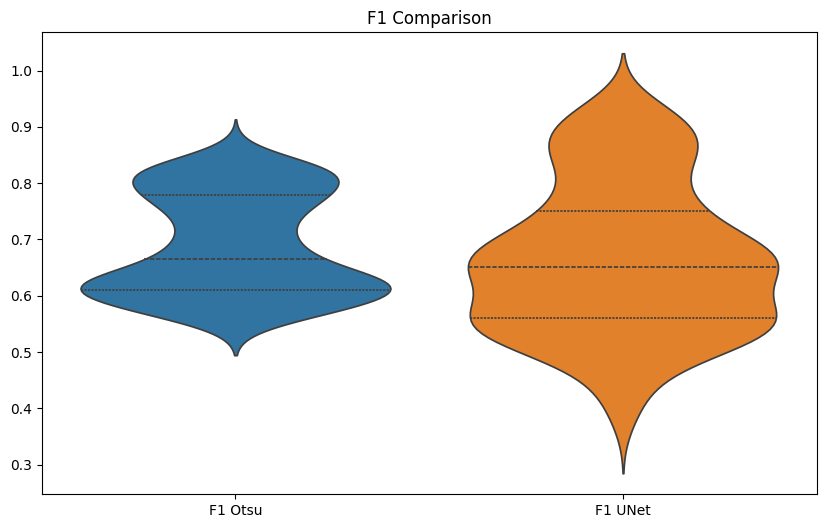

In [59]:
# Metrics
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
accuracy_otsu, precision_otsu, recall_otsu, f1_otsu = [], [], [], []

def calculate_metrics(predicted, gt):
    accuracy = accuracy_score(predicted.flatten(), gt.flatten())
    precision = precision_score(predicted.flatten(),gt.flatten())
    recall = recall_score(predicted.flatten(), gt.flatten())
    f1 = f1_score(predicted.flatten(), gt.flatten())
    return accuracy, precision,recall, f1


with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, masks = data
        images, masks = images.cuda(), masks.cuda()
        outputs = model(images)

        for j in range(len(outputs)):
            image     = images[j].cpu().numpy().squeeze()
            mask      = masks[j].cpu().numpy().squeeze()
            pred      = outputs[j].cpu().numpy().squeeze()
            pred = (pred > 0.5).astype(np.int8)
            maskOutsu = thershold_by_Otsu(image)

            accuracy, precision,recall, f1 = calculate_metrics(pred, mask)
            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

            accuracy_o, precision_o, recall_o, f1_o = calculate_metrics(maskOutsu, mask)
            accuracy_otsu.append(accuracy_o)
            precision_otsu.append(precision_o)
            recall_otsu.append(recall_o)
            f1_otsu.append(f1_o)

# Plotting results
metrics_df = pd.DataFrame({
    'Accuracy Otsu': accuracy_otsu,
    'Accuracy UNet': accuracy_list,
    'Precision Otsu': precision_otsu,
    'Precision UNet': precision_list,
    'Recall Otsu': recall_otsu,
    'Recall UNet': recall_list,
    'F1 Otsu': f1_otsu,
    'F1 UNet': f1_list,
})

# Plot Accuracy
plt.figure(figsize=(10, 6))
sns.violinplot(data=metrics_df[[ 'Accuracy Otsu','Accuracy UNet']], inner="quartile")
plt.title('Accuracy Comparison')
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
sns.violinplot(data=metrics_df[['Precision Otsu', 'Precision UNet']], inner="quartile")
plt.title('Precision Comparison')
plt.show()

# Plot MSE
plt.figure(figsize=(10, 6))
sns.violinplot(data=metrics_df[['Recall Otsu','Recall UNet']], inner="quartile")
plt.title('Recall Comparison')
plt.show()

# Plot MAE
plt.figure(figsize=(10, 6))
sns.violinplot(data=metrics_df[['F1 Otsu', 'F1 UNet']], inner="quartile")
plt.title('F1 Comparison')
plt.show()




## To-Do: small project

In [60]:
# 3D segmentation: Data from 'https://download.fht.org/jug/denoiseg/Mouse-Organoid-Cells-CBG-128_n10.zip'